# Model 10: Polarization

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model10.html

- 「文化的多様性はいかにして生じ維持されるのか？」文化進化研究の中心的な問いである。
- Axelrod (1997) は、個人は文化的差異を解消するように行動するにも関わらず、集団全体としては文化的多様性が維持される可能性があることをエージェントシミュレーションで示した。
- このモデルでは、文化的特性が複数設定されている。Each agent has $g = 5$ cultural features. Each feature takes one of ten values, denoted with the integers 0-9.

## Procedure

1. Each agent is placed in a fixed position on a square grid. (ノイマン近傍, not torus)
1. In the first timestep each agent’s trait values are picked at random.
1. Pick an agent at random (agent A: focal agent).
1. Pick one of A’s neighbours at random (agent B).
1. Copy a feature value from A to B. With probability equal to the proportion of shared cultural traits between A and B, pick one feature at random that differs between A and B, and set the A’s value of that feature to the B’s value.

- A と B が似ていれば似ているほど、インタラクションが起こりやすくなり、更に類似度が高まる。
- 3〜5の手続きを複数回繰り返したあと、どのような集団構造が生じるか？類似度が高まる方向の操作はあるが、類似度が下がる方向の操作は存在しないので、最終的には全てのエージェントが文化的に同質化することが予想される。

In [1]:
using DataFrames
using Formatting
using Plots
using Statistics

In [2]:
function make_agents(nrow::Int, ncol::Int, g::Int)::Matrix{String}
    agents = [join(rand(0:9, g)) for _ in 1:nrow * ncol]
    reshape(agents, (nrow, ncol))
end

function focal(agents::Matrix{String})::Tuple{String, Int, Int}
    nrow, ncol = size(agents)
    focal_row = rand(1:nrow)
    focal_col = rand(1:ncol)
    focal_agent = agents[focal_row, focal_col]
    (focal_agent, focal_row, focal_col)
end

function neighbor(agents::Matrix{String}, focal_row, focal_col)::Tuple{String, Int, Int}
    nrow, ncol = size(agents)
    
    neighbours = []

    if focal_row > 1
        _row = focal_row - 1
        _col = focal_col
        push!(neighbours, (agents[_row, _col], _row, _col))
    end

    if focal_col > 1
        _row = focal_row
        _col = focal_col - 1
        push!(neighbours, (agents[_row, _col], _row, _col))
    end

    if focal_row < nrow
        _row = focal_row + 1
        _col = focal_col
        push!(neighbours, (agents[_row, _col], _row, _col))
    end

    if focal_col < ncol
        _row = focal_row
        _col = focal_col + 1
        push!(neighbours, (agents[_row, _col], _row, _col))
    end

    rand(neighbours)
end

function parse_feature(feature::String)::Vector{Int}
    [parse(Int, value) for value in split(feature, "")]
end

function get_similarity(traits1::Vector{Int}, traits2::Vector{Int})::Float64
    matching_count = sum(a == b for (a, b) in zip(traits1, traits2))
    matching_count / length(traits1)
end

function polarization(; N_side::Int, g::Int, t_max::Int)::Matrix{String}
    # 1. Each agent is placed in a fixed position on a square grid.
    # 2. In the first timestep each agent’s trait values are picked at random.
    agents = make_agents(N_side, N_side, g)

    for t = 1:t_max
        # 3. Pick an agent at random (agent A: focal agent).
        (focal_agent, focal_row, focal_col) = focal(agents)

        # 4. Pick one of A’s neighbours at random (agent B).
        (neighbor_agent, neighbor_row, neighbor_col) = neighbor(agents, focal_row, focal_col)

        # 5. Copy a feature value from B to A.
        focal_agent_traits = parse_feature(focal_agent)
        neighbor_agent_traits = parse_feature(neighbor_agent)
        similarity = get_similarity(focal_agent_traits, neighbor_agent_traits)

        if rand() < similarity < 1
            _agents = enumerate(zip(focal_agent_traits, neighbor_agent_traits))
            i, _, b = rand([(i, a, b) for (i, (a, b)) in _agents if a != b])
            focal_agent_traits[i] = b
            agents[focal_row, focal_col] = join(focal_agent_traits)
        end
    end

    agents
end

function polarization(; N_side::Int, g::Int, t_vector::Vector{Int})::Vector{Matrix{String}}
    # 1. Each agent is placed in a fixed position on a square grid.
    # 2. In the first timestep each agent’s trait values are picked at random.
    agents = make_agents(N_side, N_side, g)
    
    t_max = maximum(t_vector)
    snapshots = []

    for t = 1:t_max
        # 3. Pick an agent at random (agent A: focal agent).
        (focal_agent, focal_row, focal_col) = focal(agents)

        # 4. Pick one of A’s neighbours at random (agent B).
        (neighbor_agent, neighbor_row, neighbor_col) = neighbor(agents, focal_row, focal_col)

        # 5. Copy a feature value from B to A.
        focal_agent_traits = parse_feature(focal_agent)
        neighbor_agent_traits = parse_feature(neighbor_agent)
        similarity = get_similarity(focal_agent_traits, neighbor_agent_traits)

        if rand() < similarity < 1
            _agents = enumerate(zip(focal_agent_traits, neighbor_agent_traits))
            i, _, b = rand([(i, a, b) for (i, (a, b)) in _agents if a != b])
            focal_agent_traits[i] = b
            agents[focal_row, focal_col] = join(focal_agent_traits)
        end

        if t in t_vector
            push!(snapshots, deepcopy(agents))
        end
    end

    snapshots
end;

In [3]:
function line_width(similarity::Float64)::Float64
    if similarity == 1
        0
    elseif 0.8 <= similarity < 1
        0.5
    elseif 0.6 <= similarity < 0.8
        1
    elseif 0.4 <= similarity < 0.6
        3
    elseif 0.2 <= similarity < 0.4
        5
    elseif similarity < 0.2
        7
    end
end

function polarization_plot(agents::Matrix{String}, title::String)::Plots.Plot
    N_side, _ = size(agents)
    p = plot(
        title = title,
        xshowaxis = false,
        yshowaxis = false,
        xlim = (0, N_side),
        ylim = (0, N_side),
        axes = false,
        grid = false,
        legend = false
    )

    plot!([(0, 0), (0, N_side)], color=:black)
    plot!([(0, 0), (N_side, 0)], color=:black)
    plot!([(0, N_side), (N_side, N_side)], color=:black)
    plot!([(N_side, 0), (N_side, N_side)], color=:black)
    
    # vertical lines:
    for row = 1:N_side
        for col = 1:N_side - 1
            agent1 = agents[row, col]
            agent2 = agents[row, col + 1]

            agent1_traits = parse_feature(agent1)
            agent2_traits = parse_feature(agent2)
            similarity = get_similarity(agent1_traits, agent2_traits)

            if similarity < 1.0
                plot!([(col, row - 1), (col, row)], lw=line_width(similarity), color=:black)
            end
        end
    end

    # horizontal lines:
    for row = 1:N_side - 1
        for col = 1:N_side
            agent1 = agents[row, col]
            agent2 = agents[row + 1, col]

            agent1_traits = parse_feature(agent1)
            agent2_traits = parse_feature(agent2)
            similarity = get_similarity(agent1_traits, agent2_traits)

            if similarity < 1.0
                plot!([(col - 1, row), (col, row)], lw=line_width(similarity), color=:black)
            end
        end
    end
    
    p
end

function run(; trials::Int, steps::Vector{Int}, N_side::Int, g::Int)
    for trial = 1:trials
        println("Trial $trial")
        snapshots = polarization(N_side = N_side, g = g, t_vector = steps)
        plots = [polarization_plot(snapshot, "After " * sprintf1("%'d", step) * " steps") for (snapshot, step) in zip(snapshots, steps)]
        display(plot(plots..., size = (800, 600)))
    end
end;

Trial 1


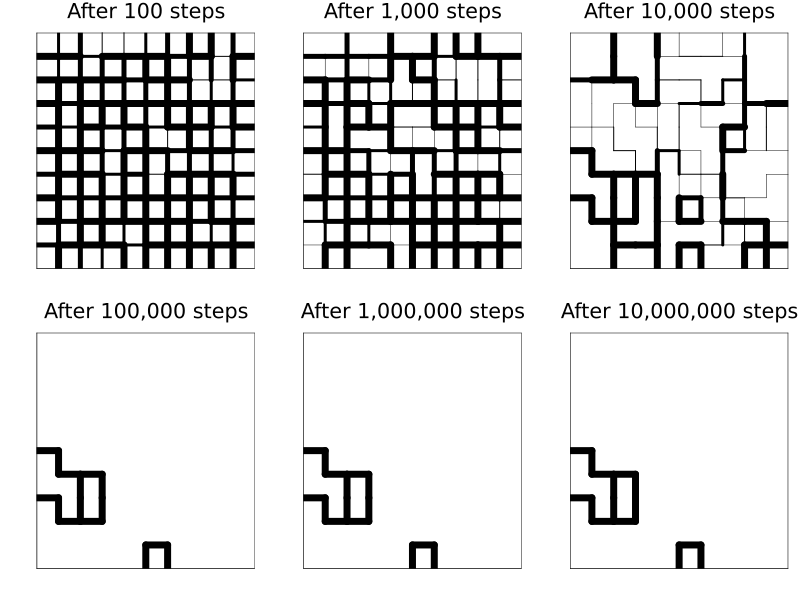

Trial 2


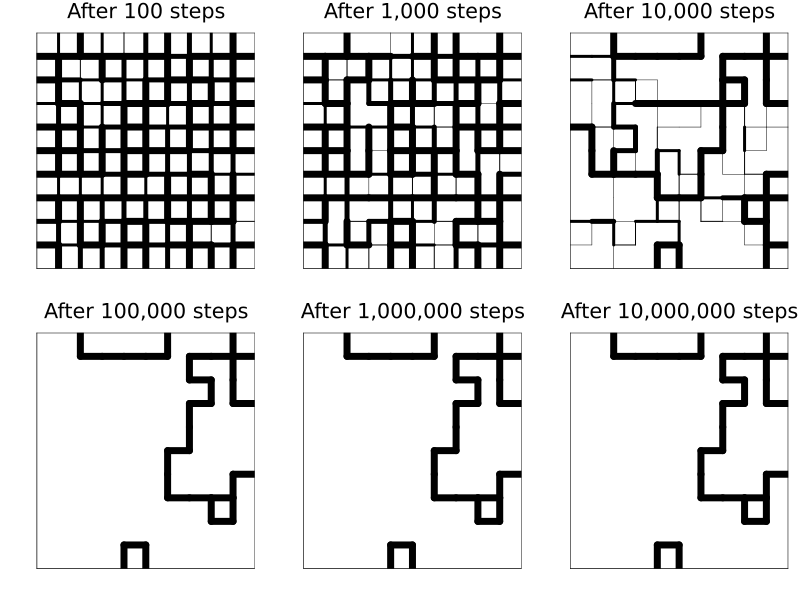

Trial 3


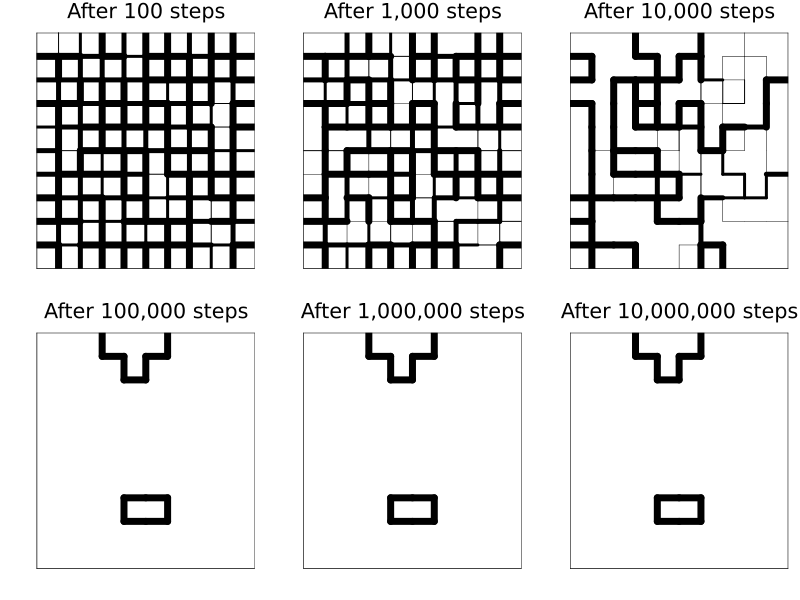

Trial 4


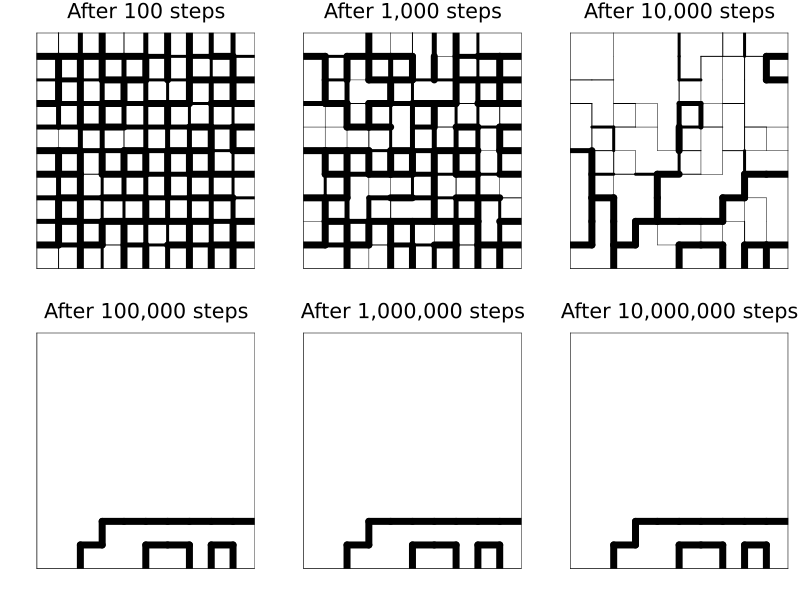

Trial 5


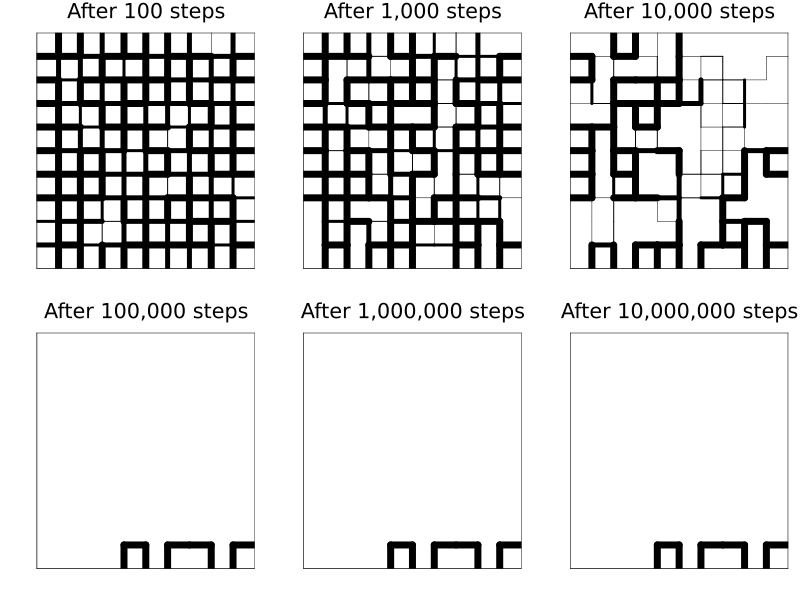

In [4]:
run(trials = 5, steps = [10^2, 10^3, 10^4, 10^5, 10^6, 10^7], N_side = 10, g = 5)

### 特徴数を増やすと分極化が起こりにくくなる

これは直感に反するが、特徴数が増えると、2人のエージェント間の共通点が見つかりやすくなると考えると納得できる。

Trial 1


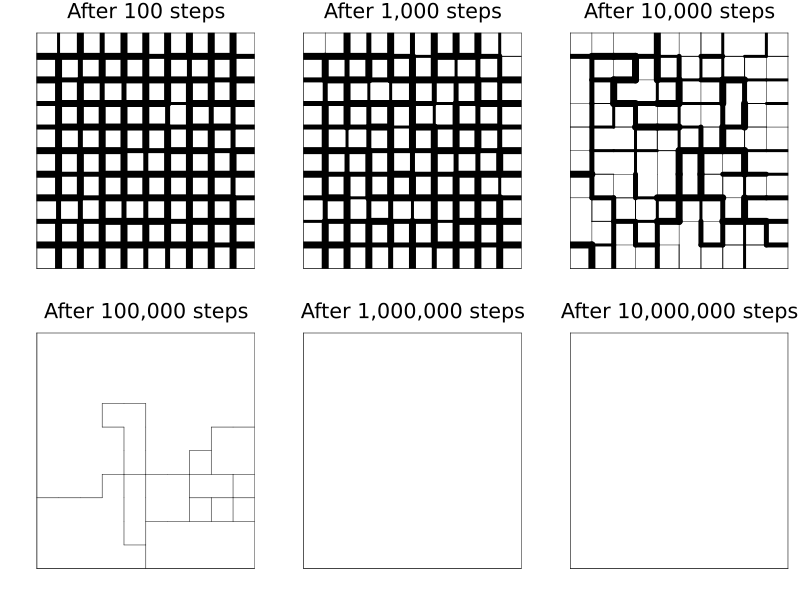

Trial 2


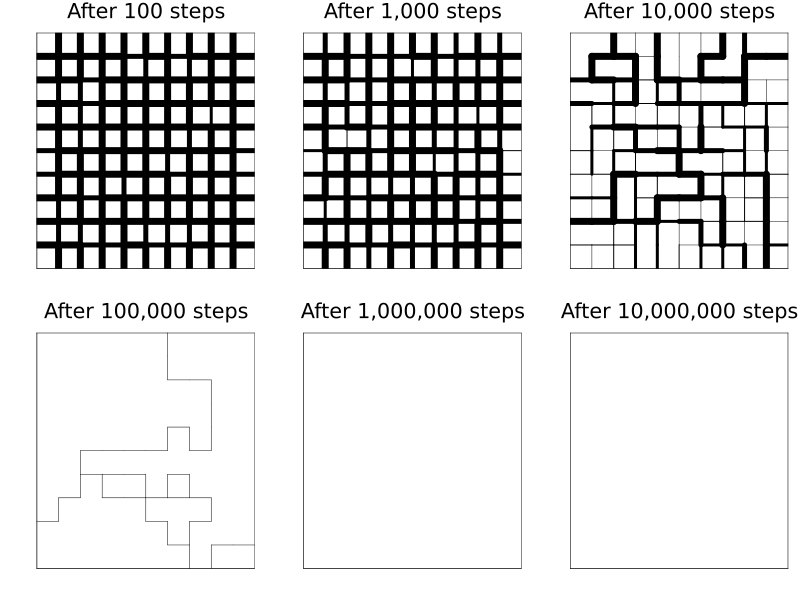

Trial 3


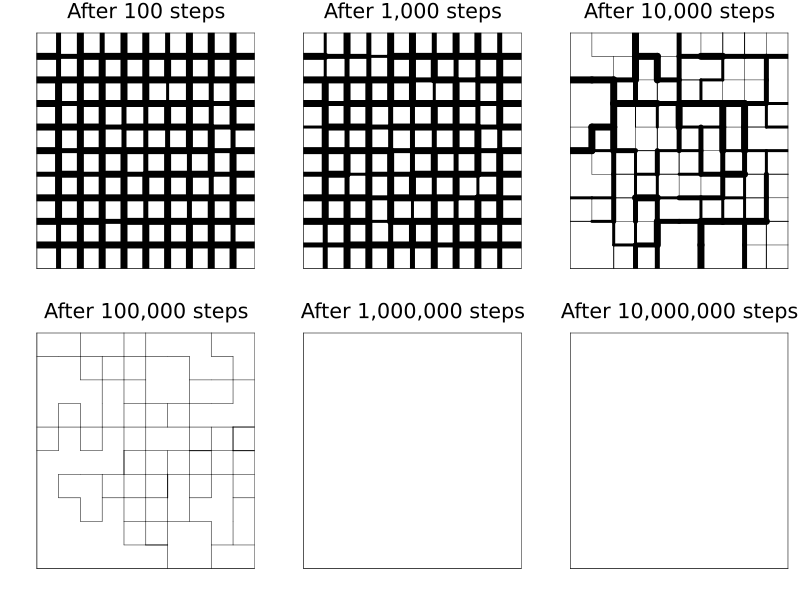

Trial 4


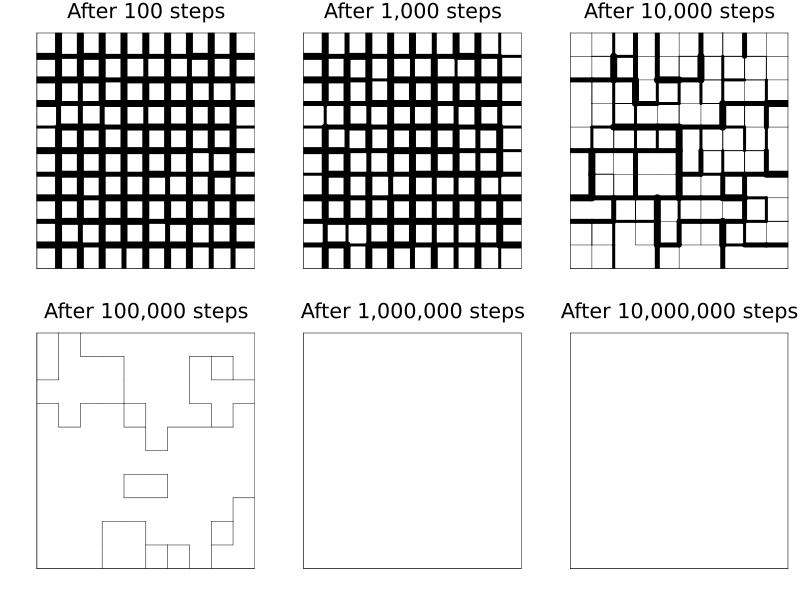

Trial 5


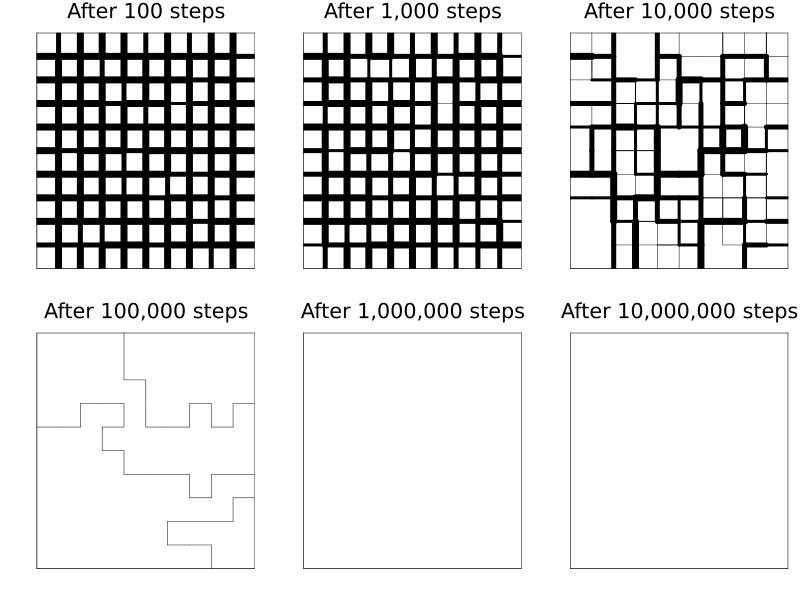

In [5]:
run(trials = 5, steps = [10^2, 10^3, 10^4, 10^5, 10^6, 10^7], N_side = 10, g = 15)

### エージェント数を増やすと分極化が起こりにくくなる

Trial 1


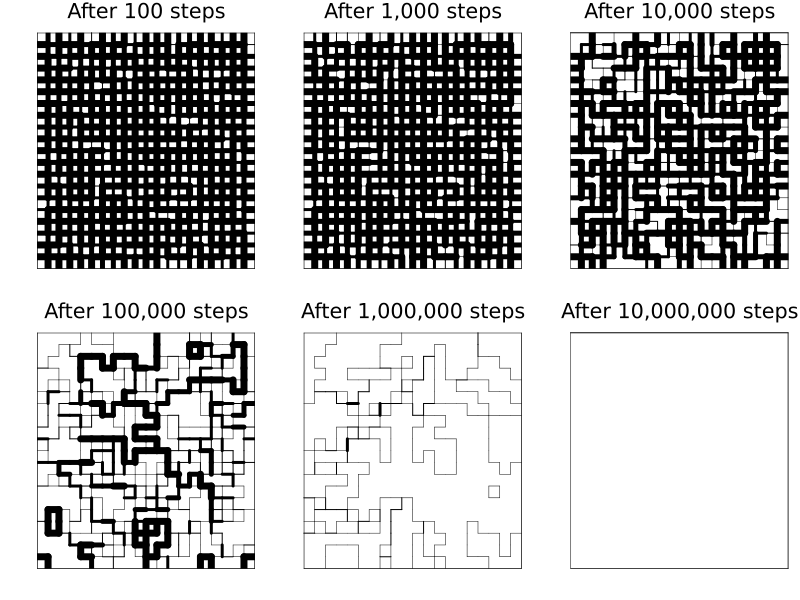

Trial 2


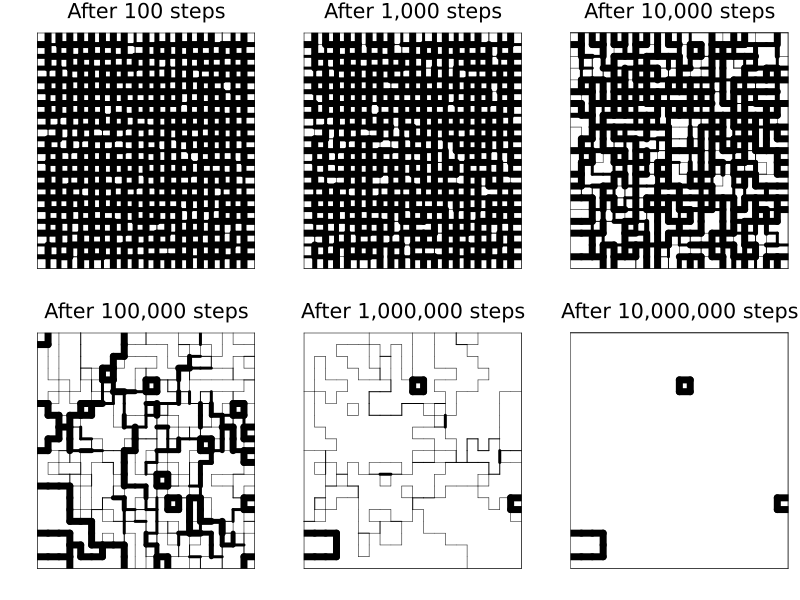

Trial 3


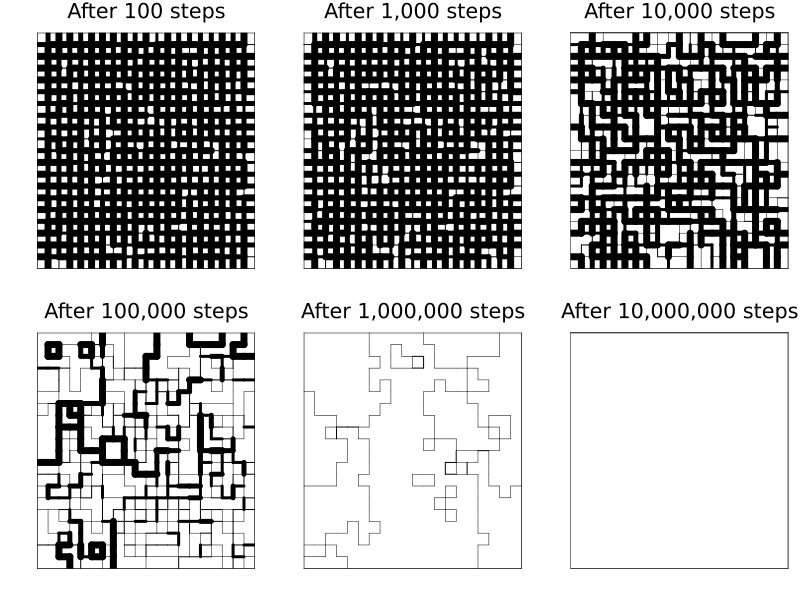

Trial 4


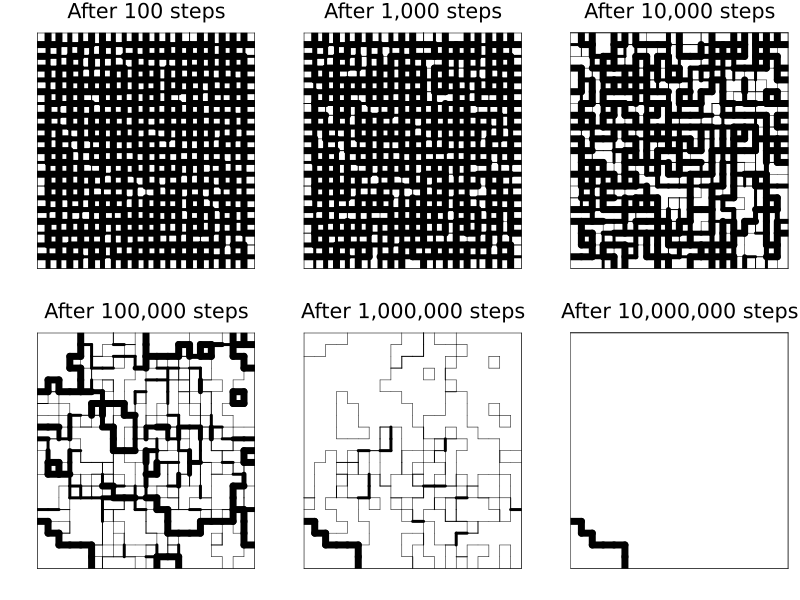

Trial 5


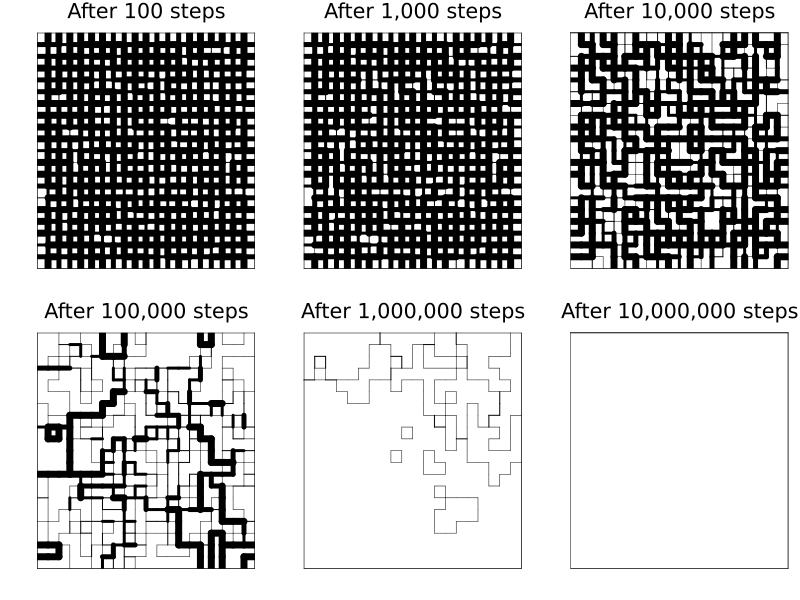

In [6]:
run(trials = 5, steps = [10^2, 10^3, 10^4, 10^5, 10^6, 10^7], N_side = 20, g = 5)

## Stability Check

In [7]:
function stable(agents::Matrix{String})::Bool
    nrow, ncol = size(agents)

    # vertical lines:
    for row = 1:nrow
        for col = 1:ncol - 1
            agent1 = agents[row, col]
            agent2 = agents[row, col + 1]

            agent1_traits = parse_feature(agent1)
            agent2_traits = parse_feature(agent2)
            similarity = get_similarity(agent1_traits, agent2_traits)

            if 0.0 < similarity < 1.0
                return false
            end
        end
    end

    # horizontal lines:
    for row = 1:nrow - 1
        for col = 1:ncol
            agent1 = agents[row, col]
            agent2 = agents[row + 1, col]

            agent1_traits = parse_feature(agent1)
            agent2_traits = parse_feature(agent2)
            similarity = get_similarity(agent1_traits, agent2_traits)

            if 0.0 < similarity < 1.0
                return false
            end
        end
    end
    
    true
end

function stable_time_step(; N_side::Int, g::Int, t_max::Int)::Vector{Int}
    # 1. Each agent is placed in a fixed position on a square grid.
    # 2. In the first timestep each agent’s trait values are picked at random.
    agents = make_agents(N_side, N_side, g)

    for t = 1:t_max
        # 3. Pick an agent at random (agent A: focal agent).
        (focal_agent, focal_row, focal_col) = focal(agents)

        # 4. Pick one of A’s neighbours at random (agent B).
        (neighbor_agent, neighbor_row, neighbor_col) = neighbor(agents, focal_row, focal_col)

        # 5. Copy a feature value from B to A.
        focal_agent_traits = parse_feature(focal_agent)
        neighbor_agent_traits = parse_feature(neighbor_agent)
        similarity = get_similarity(focal_agent_traits, neighbor_agent_traits)

        if rand() < similarity < 1
            _agents = enumerate(zip(focal_agent_traits, neighbor_agent_traits))
            i, _, b = rand([(i, a, b) for (i, (a, b)) in _agents if a != b])
            focal_agent_traits[i] = b
            agents[focal_row, focal_col] = join(focal_agent_traits)
        end

        if stable(agents)
            return [t, length(unique(agents))]
        end
    end

    [0, 0]
end;

In [8]:
function run_stability_check(; Ns::Vector{Int}, gs::Vector{Int}, t_max::Int, trials::Int)::DataFrame
    output = DataFrame(agent_count = Int[], feature_count = Int[], stable_regions = Float64[],
        average_time_steps = Int[], standard_deviation = Int[])

    for N in Ns
        for g in gs
            println("N = $N, g = $g")
            stabilities = [stable_time_step(N_side = N, g = g, t_max = t_max) for _ in 1:trials]
            stabilities = hcat(stabilities...)

            region_count = round(mean(stabilities[2, :]), digits = 2)
            _mean = Int(round(mean(stabilities[1, :])))
            _std = Int(round(std(stabilities[1, :])))

            push!(output, (agent_count = N^2, feature_count = g, stable_regions = region_count,
                    average_time_steps = _mean, standard_deviation = _std))
        end
    end

    output
end;

In [9]:
df = run_stability_check(Ns = [10, 20], gs = [5, 10, 15, 20], t_max = 10^7, trials = 10)

N = 10, g = 5
N = 10, g = 10
N = 10, g = 15
N = 10, g = 20
N = 20, g = 5
N = 20, g = 10
N = 20, g = 15
N = 20, g = 20


8×5 DataFrame
 Row │ agent_count  feature_count  stable_regions  average_time_steps  standar ⋯
     │ Int64        Int64          Float64         Int64               Int64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │         100              5             5.3               79281          ⋯
   2 │         100             10             1.0               95996
   3 │         100             15             1.0              136532
   4 │         100             20             1.0              150668
   5 │         400              5             2.0             1552838          ⋯
   6 │         400             10             1.0             1782337
   7 │         400             15             1.0             2181465
   8 │         400             20             1.0             2637734
                                                                1 column omitted

## Note

[Axelrod (1997)](https://doi.org/10.1177/0022002797041002001) は、以下を示した。
- 特徴数を増やすと分極化の度合いが減る。
- エージェント数を増やすと分極化の度合いが減る。
- 相互作用の範囲を広げる (ムーア近傍にする) と分極化の度合いが減る。

極端な分極化と同様に、完全な同質化も避けるべき状況だ。同質化を避け、文化的多様性を維持するには、他のモデルで示したような何らかのメカニズム (例えば、Mutation など) が必要である。